In [1]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType, LongType,ArrayType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import time
from pyspark.sql.window import Window
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt
import os
import iso3166

import matplotlib.ticker as plticker
from pyspark.sql.functions import monotonically_increasing_id 
import matplotlib.gridspec as gridspec
import random

In [2]:
# Imports
from importlib import reload
import os
import sys
import datetime
import time
import numpy as np
import hashlib
#import mysql.connector
import logging
import shutil
import random

#Stuff to Read Avro files
packages = '/home/sigga/spark-avro_2.12-3.0.0.jar'
os.environ["PYSPARK_SUBMIT_ARGS"] = ("--jars {0} pyspark-shell ".format(packages))


In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType,TimestampType,BooleanType,StringType, IntegerType,FloatType, DateType, DoubleType, StructType, StructField, LongType
from pyspark.sql import Window

# Create new context
spark = SparkSession.builder.config("spark.sql.files.ignoreCorruptFiles","true").config("spark.memory.fraction", "0.6").config("spark.sql.legacy.timeParserPolicy", "LEGACY").config("spark.driver.memory", "20g").config("spark.executor.memory","6g").config("spark.local.dir","/data/work/user/siggasvala/tmp/").master("local[15]").getOrCreate()


In [4]:
path = '/data/work/user/siggasvala/Sleep_away_from_home/Rebuttal/analysis_ready/'
df = spark.read.parquet(path)

In [10]:
def SEMe(List):
    import math
    return (float(np.std(List))*float(np.sqrt(math.pi/2.0)))/float(np.sqrt(len(List)))
udf_SEMe = F.udf(SEMe,FloatType())

def median(List):
    return float(np.median(List))
udf_median = F.udf(median,FloatType())

def round_of_rating(number):
    """Round a number to the closest half integer.
    >>> round_of_rating(1.3)
    1.5
    >>> round_of_rating(2.6)
    2.5
    >>> round_of_rating(3.0)
    3.0
    >>> round_of_rating(4.1)
    4.0"""

    return round(number * 2) / 2
udf_round_of_rating = F.udf(round_of_rating,FloatType())

def mid_sleep(start_time, sleep_dur_sec):
    # Cast start time to epoch time
    st = start_time[0:10] + " " + start_time[11:17] + "00"
    st_epoch = calendar.timegm(time.strptime(st, "%Y-%m-%d %H:%M:%S"))

    # Calculate mid sleep
    mid_sleep_epoch = st_epoch + sleep_dur_sec/2.0
    
    # Midsleep epochs to time
    mid_sleep_string = datetime.datetime.fromtimestamp(mid_sleep_epoch).strftime("%H:%M")
    
    return mid_sleep_string
udf_mid_sleep = F.udf(mid_sleep, StringType())

def time_to_num(time):
    hour = int(time[0:2])
    minutes = int(time[3:5])/float(60)
    time_num = hour + minutes 
    return time_num
udf_time_to_num = F.udf(time_to_num, FloatType())

In [7]:
home_w = df.where((F.col("home")==True) & (F.col("weekend")==False))
home_f = df.where((F.col("home")==True) & (F.col("weekend")==True))


In [16]:
sj_w = home_w.select("useruuid","sleep_start_str","sleep_duration_hours")
sj_f = home_f.select("useruuid","sleep_start_str","sleep_duration_hours")

sj_w = sj_w.withColumn("sleep_duration_sec",F.col("sleep_duration_hours")*3600).drop("sleep_duration_hours")
sj_f = sj_f.withColumn("sleep_duration_sec",F.col("sleep_duration_hours")*3600).drop("sleep_duration_hours")

In [17]:
sj_w = sj_w.withColumn("MS",udf_mid_sleep(F.col("sleep_start_str"),F.col("sleep_duration_sec")))
sj_f = sj_f.withColumn("MS",udf_mid_sleep(F.col("sleep_start_str"),F.col("sleep_duration_sec")))

In [18]:
sj_w = sj_w.withColumn("MS_num",udf_time_to_num(F.col("MS")))
sj_f = sj_f.withColumn("MS_num",udf_time_to_num(F.col("MS")))

In [19]:
sj_w = sj_w.withColumn("MS_num",F.when(F.col("MS_num") > 19,F.col("MS_num") - 24).otherwise(F.col("MS_num")))
sj_f = sj_f.withColumn("MS_num",F.when(F.col("MS_num") > 19,F.col("MS_num") - 24).otherwise(F.col("MS_num")))

In [20]:
sj_w = sj_w.groupby("useruuid").agg(F.mean("MS_num").alias("MSW"))
sj_f = sj_f.groupby("useruuid").agg(F.mean("MS_num").alias("MSF"))

In [21]:
sj = sj_w.join(sj_f,on="useruuid",how="inner")

In [22]:
sj.write.mode("overwrite").save("/data/work/user/siggasvala/Sleep_away_from_home/Rebuttal/SJ/")

#### Load data again afte saving

In [23]:
path = '/data/work/user/siggasvala/Sleep_away_from_home/Rebuttal/analysis_ready/'
df = spark.read.parquet(path)

df_f = df.where(F.col("weekend")==True)
df_w = df.where(F.col("weekend")==False)

travel_w = df_w.where(F.col("home")==False)
travel_f = df_f.where(F.col("home")==False)

In [25]:
sj = spark.read.parquet("/data/work/user/siggasvala/Sleep_away_from_home/Rebuttal/SJ/")
sj = sj.withColumn("SJ",F.col("MSF")-F.col("MSW")).drop("MSW")

In [58]:
delta_w = travel_w.select("useruuid",F.col("duration_median").alias("duration_median_w"),"sleep_duration_hours")
delta_f = travel_f.select("useruuid",F.col("duration_median").alias("duration_median_f"),"sleep_duration_hours")

In [61]:
w=Window.partitionBy("useruuid")
delta_w = delta_w.withColumn("duration_avg",F.mean("sleep_duration_hours").over(w))\
                 .select("useruuid","duration_median_w","duration_avg").distinct()
delta_f = delta_f.withColumn("duration_avg",F.mean("sleep_duration_hours").over(w))\
                 .select("useruuid","duration_median_f","duration_avg").distinct()


In [62]:
delta_f = delta_f.withColumn("delta_travel_f",F.col("duration_avg")-F.col("duration_median_f"))
delta_w = delta_w.withColumn("delta_travel_w",F.col("duration_avg")-F.col("duration_median_w"))

In [63]:
delta = delta_w.join(delta_f,on="useruuid",how="inner")

In [64]:
delta.count()

10823

In [65]:
sj.count()

10823

In [66]:
sj_delta = sj.join(delta,on="useruuid",how="inner")
sj_delta.count()

10823

In [67]:
sj_deltaPD = sj_delta.toPandas()

#### Prepping for plot

In [68]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [69]:
SJ_lst = sj_deltaPD.SJ.tolist()
pp = [10,25,75,90]
for p in pp:
    print(np.percentile(SJ_lst,p))

0.15512064598777542
0.4394605739669446
1.2099979506209007
1.6447067072254837


In [70]:
def SJ_split(SJ):
    if SJ < 0.155: #10 %
        return 1 
    elif (SJ>=0.155) & (SJ<0.439): #10-25 %
        return 2
    elif (SJ>=0.439) & (SJ<1.210): #25-75 %
        return 3
    elif (SJ>=1.210) & (SJ<1.645): # 75-90 %
        return 4
    elif (SJ>=1.645): # 90 -100 $
        return 5
udf_SJ_split = F.udf(SJ_split,IntegerType())

In [71]:
sj_delta = sj_delta.withColumn("quant_SJ",udf_SJ_split(F.col("SJ")))

In [72]:
SJ_quan = sj_delta.groupby("quant_SJ").agg(F.mean("delta_travel_w").alias("delta_travel_w"),\
                                             F.collect_list("delta_travel_w").alias("delta_w_list"),\
                                             F.mean("delta_travel_f").alias("delta_travel_f"),\
                                             F.collect_list("delta_travel_f").alias("delta_f_list"),\
                                             F.count("useruuid").alias("N"))

In [73]:
test = SJ_quan.toPandas()

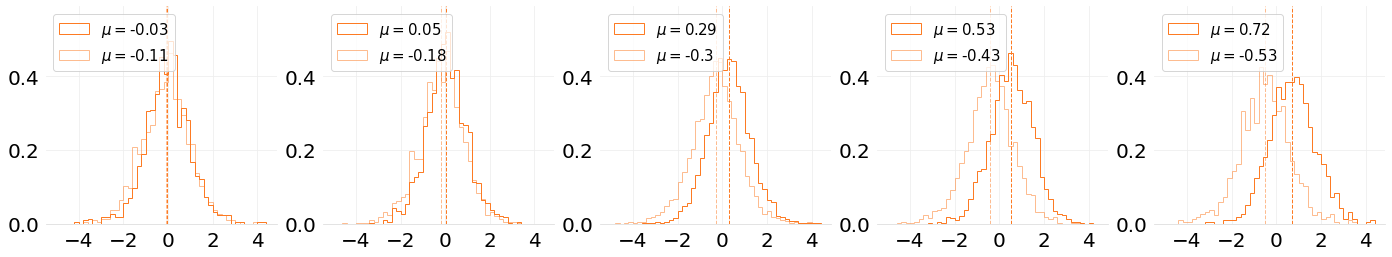

In [74]:
fig, axes = plt.subplots(1,5,figsize=(24,4))
Title = ["0-10th percentile","10-25th percentile","25-75th percentile","75-90th percentile","90-100th percentile"]
index = [1,2,3,4,5]
Bins = np.arange(-5,4.5,0.2)
C_travel = "#FD7B23"
for c,i in enumerate(index):
    list_plot_w = test[test["quant_SJ"]==i].delta_w_list.tolist()[0]
    list_plot_f = test[test["quant_SJ"]==i].delta_f_list.tolist()[0]
    mu_w = round(np.mean(list_plot_w),2)
    mu_f = round(np.mean(list_plot_f),2)
    label_w = r'$\mu=${0}'.format(mu_w)
    label_f = r'$\mu=${0}'.format(mu_f)
    axes[c].hist(list_plot_w,histtype="step", bins=Bins, label=label_w,color=C_travel,edgecolor=C_travel,density=1,lw=1)
    axes[c].hist(list_plot_f,histtype="step", bins=Bins, label=label_f,color=C_travel,edgecolor=C_travel,density=1,lw=1,alpha=0.5)
    axes[c].axvline(x=mu_w,ls="--",color=C_travel,lw=1,label=None)
    axes[c].axvline(x=mu_f,ls="--",color=C_travel,lw=1,label=None,alpha=0.5)
    
    # Axis styling.
    axes[c].spines['top'].set_visible(False)
    axes[c].spines['right'].set_visible(False)
    axes[c].spines['left'].set_visible(False)
    axes[c].spines['bottom'].set_color('#DDDDDD')
    axes[c].tick_params(bottom=False, left=False)
    axes[c].set_axisbelow(True)
    axes[c].yaxis.grid(True, color='#EEEEEE')
    axes[c].xaxis.grid(True, color='#EEEEEE')
    axes[c].tick_params(axis='y', labelsize=20)
    axes[c].tick_params(axis='x', labelsize=20)
    axes[c].legend(prop={'size': 15},loc="upper left")
    locx = plticker.MultipleLocator(base=2) 
    axes[c].xaxis.set_major_locator(locx)
    axes[c].set_ylim([0,0.59])
fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/socialjetlag_dist.pdf", bbox_inches='tight')


### Distribution of social jetlag

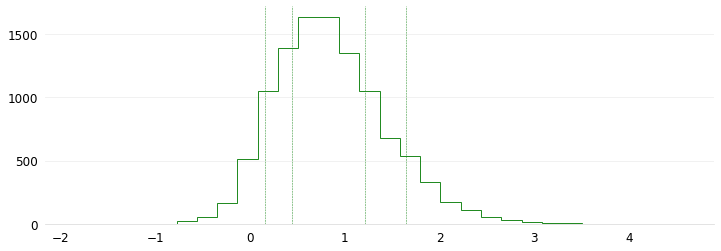

In [75]:
fig, axes = plt.subplots(1,1,figsize=(12,4))
dec = [10,25,75,90]
lines_plot = []
for d in dec:
    lines_plot.append(np.percentile(sj_deltaPD["SJ"],d))

axes.hist(sj_deltaPD["SJ"],histtype="step", bins=30, color="forestgreen",edgecolor="forestgreen",lw=1)

for line in lines_plot:
    plt.axvline(x=float(line),ls="--",color="forestgreen",lw=0.5)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(False)
axes.tick_params(axis='y', labelsize=12)
axes.tick_params(axis='x', labelsize=12)
locx = plticker.MultipleLocator(base=1) 
axes.xaxis.set_major_locator(locx)

locy = plticker.MultipleLocator(base=500) 
axes.yaxis.set_major_locator(locy)
fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/socialjetlag_dist_overall.pdf", bbox_inches='tight')


### Boxplot, social jetlag by sleep groups

In [77]:
sj_deltaPD['duration_median_w_WH'] = sj_deltaPD.duration_median_w.round()
sj_deltaPD['duration_median_f_WH'] = sj_deltaPD.duration_median_f.round()

In [78]:
sj_deltaPD = sj_deltaPD[sj_deltaPD['duration_median_f_WH']<11]
sj_deltaPD = sj_deltaPD[sj_deltaPD['duration_median_w_WH']<11]

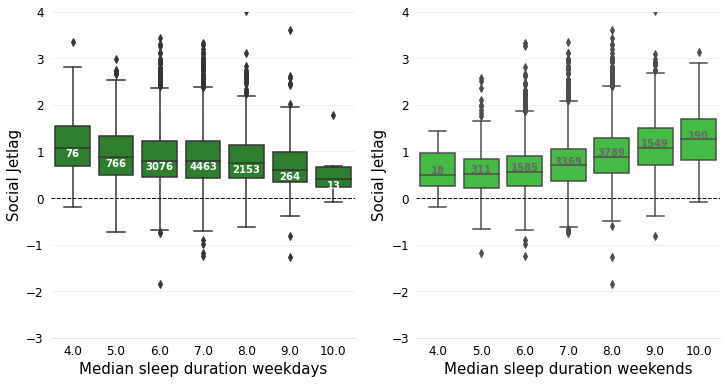

In [79]:
import seaborn as sns
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(12,6))

sns.boxplot(x='duration_median_w_WH', y='SJ', data=sj_deltaPD,color="forestgreen",ax= ax[0])
ax[0].set_xlabel("Median sleep duration weekdays",size=15,color="k")
ax[0].set_ylabel("Social Jetlag",size=15,color="k")
ax[0].axhline(y=0,color="k",lw=1,ls="--")
locy = plticker.MultipleLocator(base=1) 
ax[0].yaxis.set_major_locator(locy)
ax[0].set_ylim([-3,4])


medians = sj_deltaPD.groupby(['duration_median_w_WH'])['SJ'].median().to_dict()
nobs = sj_deltaPD['duration_median_w_WH'].value_counts().to_dict()
nobs_label = {}
for k,v in nobs.items():
    nobs_label[k] = str(v)
pos = range(len(nobs))
for tick,label in zip(pos,ax[0].get_xticklabels()):
    ax[0].text(pos[tick], medians[float(label.get_text())] - 0.2, nobs_label[float(label.get_text())],
                horizontalalignment='center', size='medium', color='w', weight='semibold')


sns.boxplot(x='duration_median_f_WH', y='SJ', data=sj_deltaPD,color="limegreen",ax= ax[1])
ax[1].set_xlabel("Median sleep duration weekends",size=15,color="k")
ax[1].set_ylabel("Social Jetlag",size=15,color="k")
ax[1].axhline(y=0,color="k",lw=1,ls="--")
locy = plticker.MultipleLocator(base=1) 
ax[1].yaxis.set_major_locator(locy)
ax[1].set_ylim([-3,4])


medians = sj_deltaPD.groupby(['duration_median_f_WH'])['SJ'].median().to_dict()
nobs = sj_deltaPD['duration_median_f_WH'].value_counts().to_dict()
nobs_label = {}
for k,v in nobs.items():
    nobs_label[k] = str(v)
pos = range(len(nobs))
for tick,label in zip(pos,ax[1].get_xticklabels()):
    ax[1].text(pos[tick], medians[float(label.get_text())] + 0.03, nobs_label[float(label.get_text())],
                horizontalalignment='center', size='medium', color='dimgray', weight='semibold')
# Axis styling.
for i in range(2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')
    ax[i].tick_params(bottom=False, left=False)
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].tick_params(axis='x', labelsize=12)
fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/socialjetlag_duration_box.pdf", bbox_inches='tight')


### Explore delta by sleep groups on weekends and compare to weekdays

In [80]:
weekdays = df.where((F.col("weekend")==False) & (F.col("home")==False))\
             .select("useruuid","sleep_duration_hours","duration_median",\
                      "duration_median_WH","weekend")

In [81]:
weekends = df.where((F.col("weekend")==True) & (F.col("home")==False))\
             .select("useruuid","sleep_duration_hours","duration_median",\
                      "duration_median_WH","weekend")

In [82]:
weekdays = weekdays.groupby("useruuid","weekend","duration_median","duration_median_WH").agg(F.mean("sleep_duration_hours").alias("duration_avg"))
weekends = weekends.groupby("useruuid","weekend","duration_median","duration_median_WH").agg(F.mean("sleep_duration_hours").alias("duration_avg"))


In [83]:
weekdays = weekdays.withColumn("duration_diff",F.col("duration_avg")-F.col("duration_median"))
weekends = weekends.withColumn("duration_diff",F.col("duration_avg")-F.col("duration_median"))

In [84]:
weekdays.count()

19812

In [85]:
weekends.count()

13515

In [86]:
df_bar = weekdays.unionAll(weekends)
df_bar.count()

33327

In [87]:
bar_delta = df_bar.toPandas()

In [88]:
bar_delta = bar_delta[(bar_delta["duration_median"]>=4.5)&(bar_delta["duration_median"]<=9.5)]

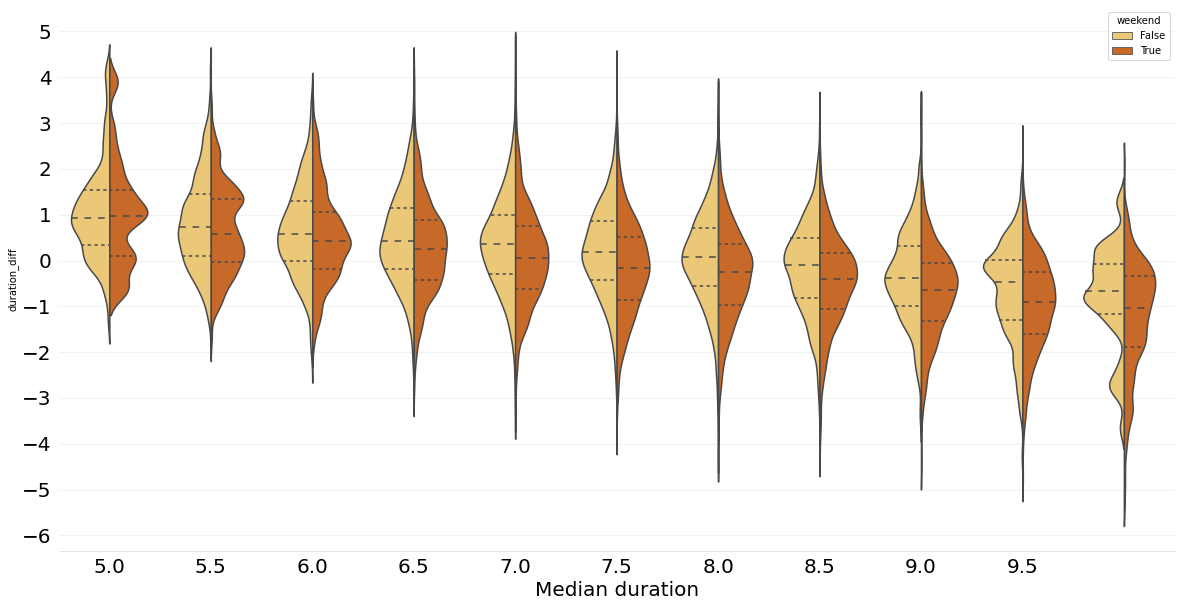

In [90]:
fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(20,10))

sns.violinplot(x="duration_median_WH", y="duration_diff", hue="weekend",
                    data=bar_delta, palette="YlOrBr", split=True,ax=axes,inner='quartile',
              scale_hue=False,bw=.2)
# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(False)
axes.tick_params(axis='y', labelsize=20)
axes.tick_params(axis='x', labelsize=20)
locx = plticker.MultipleLocator(base=1) 
axes.xaxis.set_major_locator(locx)
locy = plticker.MultipleLocator(base=1) 
axes.yaxis.set_major_locator(locy)
axes.set_xlabel("Median duration",fontsize=20)
fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/delta_weekend_weekday_violin.pdf", bbox_inches='tight')


### Aggregate by sleep groups with weekdays

In [91]:
home_w = df_w.where(F.col("home")==True)
home_f = df_f.where(F.col("home")==True)

travel_w = df_w.where(F.col("home")==False)
travel_f = df_f.where(F.col("home")==False)

In [92]:
# Find highest ratio
w=Window.partitionBy("useruuid")

var = "sleep_duration_hours"
var_list = ["useruuid",var,"day_label_sleep"]

# WEEKDAYS: Estimate standard error of the median at home, average at home, SEM of average at home
home_w_agg = home_w.select(var_list).withColumn("var_list",F.collect_list(var).over(w))\
                                    .withColumn("home_avg",F.mean(var).over(w))\
                                    .withColumn("var_home_std",F.stddev(var).over(w))\
                                    .withColumn("N_home",F.count(var).over(w))
            
# WEEKENDS: Estimate standard error of the median at home, average at home, SEM of average at home
home_f_agg = home_f.select(var_list).withColumn("var_list",F.collect_list(var).over(w))\
                                    .withColumn("home_avg",F.mean(var).over(w))\
                                    .withColumn("var_home_std",F.stddev(var).over(w))\
                                    .withColumn("N_home",F.count(var).over(w))

home_w_agg = home_w_agg.withColumn("home_SEM",F.col("var_home_std")/F.sqrt(F.col("N_home"))).drop("var_home_std").drop("N_home")
home_w_agg = home_w_agg.withColumn("home_SEMe",udf_SEMe(F.col("var_list")))\
                       .withColumn("home_median",udf_median(F.col("var_list")))\
                       .withColumn("home_median_WH",udf_round_of_rating(F.col("home_median"))).drop("var_list")
        
home_f_agg = home_f_agg.withColumn("home_SEM",F.col("var_home_std")/F.sqrt(F.col("N_home"))).drop("var_home_std").drop("N_home")
home_f_agg = home_f_agg.withColumn("home_SEMe",udf_SEMe(F.col("var_list")))\
                       .withColumn("home_median",udf_median(F.col("var_list")))\
                       .withColumn("home_median_WH",udf_round_of_rating(F.col("home_median"))).drop("var_list")

# Average sleep duration away from home and estimate its standard error of the mean 
travel_w_agg = travel_w.select(var_list).withColumn("away_avg",F.mean(var).over(w))\
                                        .withColumn("away_std",F.stddev(var).over(w))\
                                        .withColumn("N_travel",F.count("day_label_sleep").over(w))
travel_f_agg = travel_f.select(var_list).withColumn("away_avg",F.mean(var).over(w))\
                                        .withColumn("away_std",F.stddev(var).over(w))\
                                        .withColumn("N_travel",F.count("day_label_sleep").over(w))
        
travel_w_agg = travel_w_agg.withColumn("travel_SEM",F.col("away_std")/F.sqrt(F.col("N_travel"))).drop("away_std").drop("N_travel")
travel_f_agg = travel_f_agg.withColumn("travel_SEM",F.col("away_std")/F.sqrt(F.col("N_travel"))).drop("away_std").drop("N_travel")

In [93]:
home_w_agg = home_w_agg.select("useruuid","home_median","home_SEMe","home_avg","home_SEM","home_median_WH").distinct()
home_f_agg = home_f_agg.select("useruuid","home_median","home_SEMe","home_avg","home_SEM","home_median_WH").distinct()

travel_w_agg = travel_w_agg.select(F.col("useruuid").alias("dummy_id"),"away_avg","travel_SEM").distinct()
travel_f_agg = travel_f_agg.select(F.col("useruuid").alias("dummy_id"),"away_avg","travel_SEM").distinct()

df_agg_w = home_w_agg.join(travel_w_agg,F.col("useruuid")==F.col("dummy_id"),"inner").drop("dummy_id")
df_agg_f = home_f_agg.join(travel_f_agg,F.col("useruuid")==F.col("dummy_id"),"inner").drop("dummy_id")

In [94]:
df_agg_w = df_agg_w\
          .withColumn("diff_travel",F.col("away_avg")- F.col("home_median"))\
          .withColumn("diff_travel_SEM2",F.col("travel_SEM")*F.col("travel_SEM") + F.col("home_SEMe")*F.col("home_SEMe"))\
          .withColumn("diff_home",F.col("home_avg")- F.col("home_median"))\
          .withColumn("diff_home_SEM2",F.col("home_SEM")*F.col("home_SEM") + F.col("home_SEMe")*F.col("home_SEMe"))\
        
df_agg_f = df_agg_f\
          .withColumn("diff_travel",F.col("away_avg")- F.col("home_median"))\
          .withColumn("diff_travel_SEM2",F.col("travel_SEM")*F.col("travel_SEM") + F.col("home_SEMe")*F.col("home_SEMe"))\
          .withColumn("diff_home",F.col("home_avg")- F.col("home_median"))\
          .withColumn("diff_home_SEM2",F.col("home_SEM")*F.col("home_SEM") + F.col("home_SEMe")*F.col("home_SEMe"))


In [95]:
avg_f = df_agg_f.groupby("home_median_WH")\
                .agg(F.mean("diff_travel").alias("diff_travel_avg"),\
                     F.sum("diff_travel_SEM2").alias("diff_travel_SEM2"),\
                     F.mean("diff_home").alias("diff_home_avg"),\
                     F.sum("diff_home_SEM2").alias("diff_home_SEM2"),\
                     F.count("useruuid").alias("N"))
    
avg_f = avg_f.withColumn("SEM_diff_travel",F.sqrt(F.col("diff_travel_SEM2"))/F.col("N"))\
             .withColumn("SEM_diff_home",F.sqrt(F.col("diff_home_SEM2"))/F.col("N"))
avg_fPD = avg_f.toPandas()

avg_w = df_agg_w.groupby("home_median_WH")\
                .agg(F.mean("diff_travel").alias("diff_travel_avg"),\
                     F.sum("diff_travel_SEM2").alias("diff_travel_SEM2"),\
                     F.mean("diff_home").alias("diff_home_avg"),\
                     F.sum("diff_home_SEM2").alias("diff_home_SEM2"),\
                     F.count("useruuid").alias("N"))
    
avg_w = avg_w.withColumn("SEM_diff_travel",F.sqrt(F.col("diff_travel_SEM2"))/F.col("N"))\
             .withColumn("SEM_diff_home",F.sqrt(F.col("diff_home_SEM2"))/F.col("N"))
avg_wPD = avg_w.toPandas()

In [96]:
avg_fPD = avg_fPD[(avg_fPD["home_median_WH"]>=4.5) & (avg_fPD["home_median_WH"]<=9.5)]
avg_fPD = avg_fPD.sort_values(by ="home_median_WH",ascending=True )

avg_wPD = avg_wPD[(avg_wPD["home_median_WH"]>=4.5) & (avg_wPD["home_median_WH"]<=9.5)]
avg_wPD = avg_wPD.sort_values(by ="home_median_WH",ascending=True )

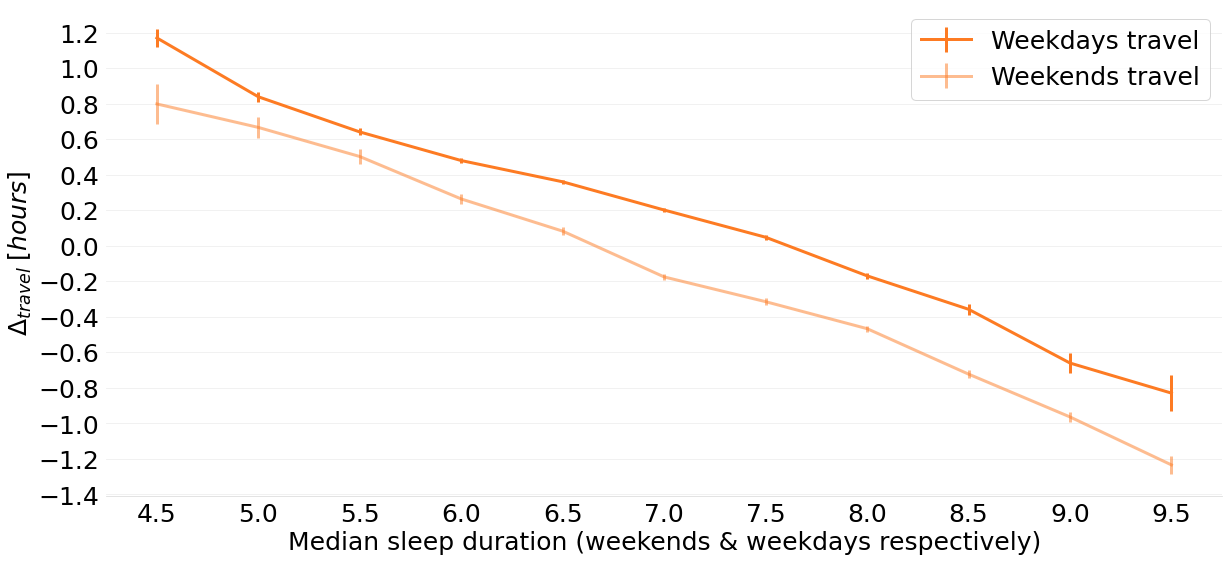

In [98]:
%matplotlib inline
fig, axes = plt.subplots(1,1,figsize=(20,9))

axes.errorbar(avg_wPD["home_median_WH"],avg_wPD["diff_travel_avg"],color="#FD7B23",fmt='-',yerr=avg_wPD["SEM_diff_travel"],lw=3,label="Weekdays travel")
axes.errorbar(avg_fPD["home_median_WH"],avg_fPD["diff_travel_avg"],color="#FD7B23",fmt='-',yerr=avg_fPD["SEM_diff_travel"],lw=3,label="Weekends travel",alpha=0.5)

axes.set_ylabel(r'$\Delta_{travel} \; [hours]$ ',fontsize=25,color="k")
axes.set_xlabel("Median sleep duration (weekends & weekdays respectively)",fontsize=25,color="k")

locy = plticker.MultipleLocator(base=0.2)
locx = plticker.MultipleLocator(base=0.5)
axes.yaxis.set_major_locator(locy)
axes.xaxis.set_major_locator(locx)
axes.legend(prop={'size': 25},loc="upper right")
fig.savefig("overall.pdf", bbox_inches='tight')
axes.tick_params(axis='y', labelsize=25)
axes.tick_params(axis='x', labelsize=25)

# Axis styling.
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.tick_params(bottom=False, left=False)
axes.set_axisbelow(True)
axes.yaxis.grid(True, color='#EEEEEE')
axes.xaxis.grid(False)
fig.savefig("/home/sigga/sleep_away_from_home/Rebuttal Nature/diff_travel_home_by_median_duration.pdf", bbox_inches='tight')
